In [1]:
import numpy as np
import cv2
from scipy import fftpack
from matplotlib import pyplot as plt

In [2]:
class Retinex:
     
    def set_param(self,img):
        r = img[...,2]
        g = img[...,1]
        b = img[...,0]
        self.param = [self.gau_process(r),self.gau_process(g),self.gau_process(b)]

    
    def gau_process(self,I):

        I_d = np.array(I).astype('float')
        I_log = np.log(I_d+1)
        f_I = fftpack.fft(I_d)
        Ir = img[...,0]
        sigma = [15,80,250]
        x,y = np.meshgrid(range((-(np.shape(Ir)[1]-1)/2),(np.shape(Ir)[1])/2),range((-(np.shape(Ir)[0]-1)/2),(np.shape(Ir)[0])/2))
        Reti = []

        for sig in sigma:
            Gauss = np.exp(-(x^2+y^2)/(2*sig^2))/sum(np.exp(-(x^2+y^2)/(2*sig^2)))
            fgauss = fftpack.fft2(Gauss,np.shape(I))
            fgauss = fftpack.fftshift(fgauss)
            R = fftpack.ifft2(fgauss*f_I)
            min1 = R.min()
            R_log = np.log(R-min1+1)
            R = I_log-R_log
            Reti.append(R)

        return Reti

    def clamp(self,R):
        low = R.min()
        high = R.max()
        return (255*(R-low)/(high-low)).astype('uint8')

    def getSSR(self,param):
        SSR = param[1]
        return self.clamp(SSR)

    def getMSR(self,param):
        MSR = 0.33*param[0]+0.34*param[1]+0.33*param[2]
        return self.clamp(MSR)

    def getMSRCR(self,param,CR_param,cur_l):
        G = CR_param[0]
        b = CR_param[1]
        alpha = CR_param[2]
        beta = CR_param[3]
        Ir_d = CR_param[4]
        Ig_d = CR_param[5]
        Ib_d = CR_param[6]
        CR = beta*(np.log(alpha*CR_param[4+cur_l]+1)-np.log(Ir_d+Ig_d+Ib_d+1))
        R_temp = 0.33*param[0]+0.34*param[1]+0.33*param[2]
        R = G*(CR*R_temp+b)
        return self.clamp(R)


    def SSR(self,img):
        ssr = img.copy()
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        for i in range(0,3):
            SSR = self.getSSR(self.param[i])
            ssr[...,i] = SSR 
        return ssr

    def MSR(self,img):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        msr = img.copy()
        for i in range(0,3):
            MSR = self.getMSR(self.param[i])
            msr[...,i] = MSR
        return msr 

    def MSRCR(self,img):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        msrcr = img.copy()
        G = 192
        b = -30
        alpha = 125
        beta = 46
        I_d = []
        for i in range(0,3):
            S = img[...,i]
            I_dt = np.array(S).astype('float')
            I_d.append(I_dt)
            
        MSRCR_param = [G,b,alpha,beta,I_d[0],I_d[1],I_d[2]]   
        
        for j in range(0,3):
            MSRCR = self.getMSRCR(self.param[j],MSRCR_param,j)
            msrcr[...,j] = MSRCR
        return msrcr

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


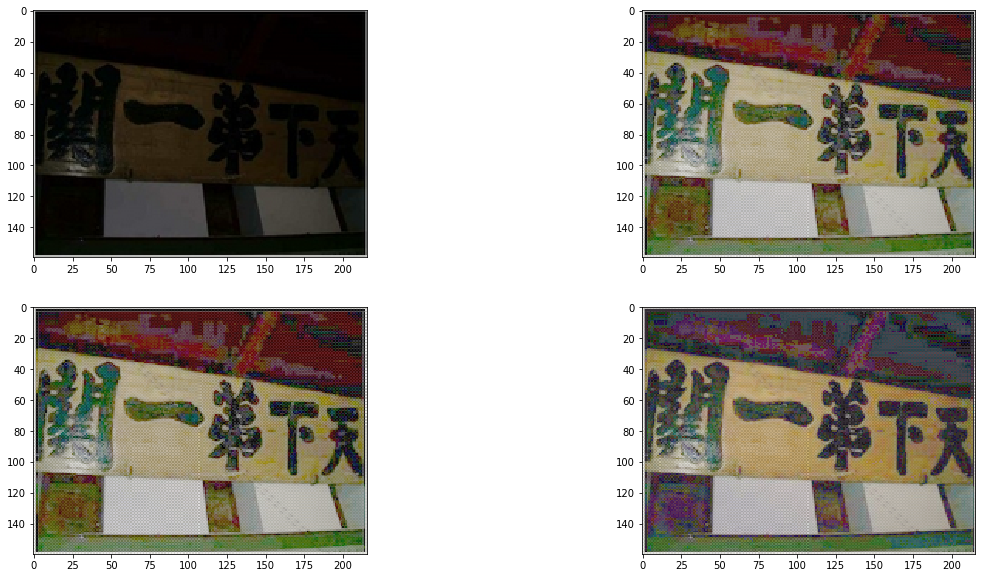

In [3]:

img_pwd = 'test2.png'
img = cv2.imread(img_pwd)

retinex = Retinex()
retinex.set_param(img)
ssr = retinex.SSR(img)
msr = retinex.MSR(img)
msrcr = retinex.MSRCR(img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(img)
plt.subplot(222),plt.imshow(msr)
plt.subplot(223),plt.imshow(ssr)
plt.subplot(224),plt.imshow(msrcr)
plt.show()